In [183]:
import pandas as pd
import pickle
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sns
import os
from tqdm import tqdm

sns.set(style="ticks", font="Arial", font_scale=1.2)

In [184]:
CONCEPTS = ["a finch", "a robin", "a chicken", "an eagle", "an ostrich", "a penguin", "a salmon", "a seal", "a dolphin", "a whale", "Abraham Lincoln", "Barack Obama", "Bernie Sanders", "Donald Trump", "Elizabeth Warren", "George W. Bush", "Hillary Clinton", "Joe Biden", "Richard Nixon", "Ronald Reagan"]
CONCEPT_CATEGORY_PAL = {"animals": sns.color_palette()[1], "politicians": sns.color_palette()[0]}

def add_model_meta_data(df):
    family_map = {
        "openchat": "openchat_starling",
        "starling": "openchat_starling",
        "gemma-instruct": "gemma",
        "zephyr-gemma": "gemma",
        "mistral-instruct": "mistral",
        "zephyr-mistral": "mistral",
        "llama2": "llama",
        "llama2-chat": "llama",
        "tulu": "llama",
        "tulu-dpo": "llama",
        "human": "human"
    }
    align_map = {
        "openchat": False,
        "starling": True,
        "gemma-instruct": False,
        "zephyr-gemma": True,
        "mistral-instruct": False,
        "zephyr-mistral": True,
        "llama2": False,
        "llama2-chat": True,
        "tulu": False,
        "tulu-dpo": True,
        "human": None
    }
    df["model_family"] = df.model_name.map(family_map)
    df["aligned"] = df.model_name.map(align_map)
    return df

plot_type = "P(1 concept)"
data_dir = "./output-data/concept-task/all/"
# add subfolder for this plot type if it doesn't exist
figure_dir = "./figures/concept-task/" + plot_type + "/"
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

print("Loading compiled data...")
all_ClusteringResults = pd.read_pickle(f"{data_dir}all-ClusteringResults.pickle")
all_ClusteringResults = add_model_meta_data(all_ClusteringResults)
all_ClusteringResults.head()

Loading compiled data...


,Concept,Iteration,S_Chao1,NumberOfPeople,NumberOfTrials,Prior,Tables,Alpha,Posterior,Chain,ProbabilityOfSameTable,model_name,prompt,temperature,concept_category,model_family,aligned
398,Hillary Clinton,499,2.00,25,36,Simplicity,2,0.16,-588.592125,1,0.9232,openchat,none,default,politicians,openchat_starling,False
797,Donald Trump,499,3.96,25,36,Simplicity,3,0.16,-585.066291,1,0.8496,openchat,none,default,politicians,openchat_starling,False
1196,Joe Biden,499,3.96,25,36,Simplicity,3,0.16,-555.428631,1,0.8496,openchat,none,default,politicians,openchat_starling,False
1595,Elizabeth Warren,499,1.00,25,36,Simplicity,1,0.16,-565.094875,1,1.0000,openchat,none,default,politicians,openchat_starling,False
1994,Ronald Reagan,499,2.00,25,36,Simplicity,2,0.16,-562.466626,1,0.9232,openchat,none,default,politicians,openchat_starling,False


/var/folders/72/ykl8sn4d11nfbqbbzl2v6znc0000gq/T/ipykernel_61822/2936917105.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


{'animals': 0.4457946199418279, 'politicians': 0.2595193080336046}

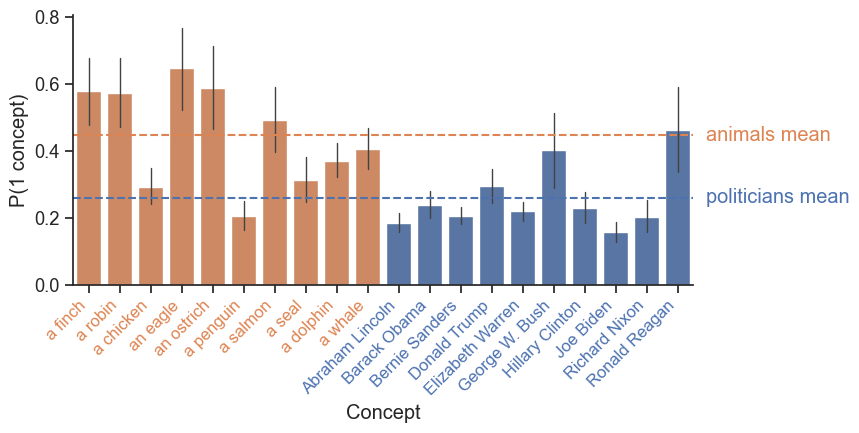

In [186]:
def plot_1concept_human(df):
    human_data = df[df.model_name=="human"]
    all_concept_colors = [CONCEPT_CATEGORY_PAL["animals"] for _ in range(10)] + [CONCEPT_CATEGORY_PAL["politicians"] for _ in range(10)]
    ax = sns.barplot(
        data=human_data,
        x="Concept",
        order=CONCEPTS,
        palette=all_concept_colors,
        y="ProbabilityOfSameTable",
        err_kws={'linewidth': 1}
    )
    ax.set_xticks(range(len(CONCEPTS)), CONCEPTS, ha="right", rotation=45, size="small")
    for i, xt in enumerate(ax.get_xticklabels()):
        xt.set_color(all_concept_colors[i])
    ax.set_ylabel("P(1 concept)")
    
    # Plot averages.
    category_means = {}
    for i, category in enumerate(["animals", "politicians"]):
        category_mean = human_data[human_data.concept_category==category]["ProbabilityOfSameTable"].mean()
        category_means[category] = category_mean
        ax.axhline(
            category_mean,
            linestyle="--",
            color=CONCEPT_CATEGORY_PAL[category]
        )
        trans = transforms.blended_transform_factory(
            ax.transAxes, ax.transData
        )
        ax.text(
            1.02, category_mean, 
            category + " mean", 
            transform=trans,
            va="center", ha="left",
            color=CONCEPT_CATEGORY_PAL[category]
        )

    plt.gcf().set_size_inches(8, 3.5)
    sns.despine()
    plt.savefig("figures/concept-task/P(1 concept)/human_baseline.pdf", bbox_inches="tight")
    return category_means
    
human_means = plot_1concept_human(all_ClusteringResults)
human_means

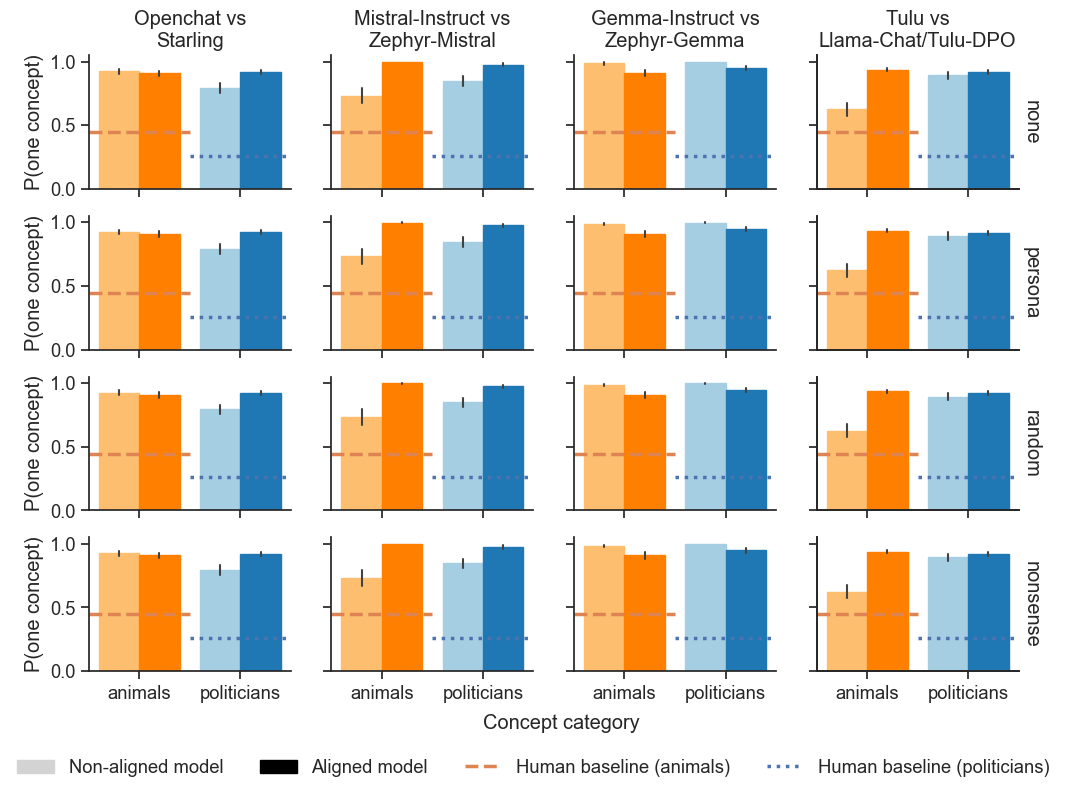

In [192]:
def plot_1concept_category_means(df, human_means=None):
    paired = sns.color_palette("Paired")
    lb, db = paired[0], paired[1] # light blue, dark blue
    lo, do = paired[6], paired[7] # light orange, dark orange
    bar_colors = [lo, lb, do, db]
    
    prompts = ["none", "identity", "random", "nonsense"]
    pretty_prompts = ["none", "persona", "random", "nonsense"]
    
    families = ["openchat_starling", "mistral", "gemma", "llama"]
    titles = [
        "Openchat vs\nStarling",
        "Mistral-Instruct vs\nZephyr-Mistral",
        "Gemma-Instruct vs\nZephyr-Gemma",
        "Tulu vs\nLlama-Chat/Tulu-DPO"
    ]
    fig, axes = plt.subplots(
        nrows=len(prompts), ncols=len(families), 
        sharey=True, sharex=True,
        figsize=(12,8)
    )
    
    category_order = ["animals", "politicians"]
    for i, prompt in enumerate(prompts):
        for j, family in enumerate(families):
            ax = axes[i][j]
            ax = sns.barplot(
                data=df[df.model_family==family],
                x="concept_category",
                order=category_order,
                y="ProbabilityOfSameTable",
                hue="aligned",
                hue_order=[False, True],
                err_kws={"linewidth": 1.5},
                ax=ax
            )
            if i == 0:
                ax.set_title(titles[j])
            ax.set_xlabel("")
    
            if j == len(families)-1:
                ax2 = ax.twinx()
                ax2.set_ylabel(pretty_prompts[i], rotation=-90, labelpad=16)
                ax2.set_yticks([])
                
            for bar_idx, bar in enumerate(ax.patches):
                if bar.get_height() != 0:
                    bar.set_color(bar_colors[bar_idx])

            if j == 0:
                ax.set_ylabel("P(one concept)")
                
            # Add dashed lines corresponding to human category-level means.
            if human_means is not None:
                styles = ["--", ":"]
                for k, category in enumerate(category_order):
                    ax.axhline(
                        human_means[category],
                        linestyle=styles[k],
                        color=CONCEPT_CATEGORY_PAL[category], 
                        label=f"Human baseline ({category})",
                        xmin=k*0.5,
                        xmax=(k+1)*0.5,
                        lw=2.5
                    )

            ax.get_legend().remove()
            
    # Add global x-axis label.
    axes[-1][1].text(1, -0.45, "Concept category")
    
    # Custom legend.
    handles, labels = axes[-1][1].get_legend_handles_labels()
    handles[0].set_color("lightgrey")
    handles[1].set_color("black")
    axes[-1][1].legend(
        handles, 
        ["Non-aligned model", "Aligned model"] + labels[2:],
        bbox_to_anchor=(1,-0.53), loc="upper center",
        ncols=4,
        frameon=False
    )
    sns.despine()


model_data = all_ClusteringResults[all_ClusteringResults.model_name != "human"]
plot_1concept_category_means(model_data, human_means=human_means)
plt.savefig("figures/concept-task/P(1 concept)/prompts.pdf", bbox_inches="tight")